<a href="https://www.kaggle.com/code/ahmadibraheeem/music-genres-classifier-logreg-vs-tree?scriptVersionId=149459984" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Data Preparation

#### After loading the datasets, we merge them to get a consolidated view. 
#### The 'info' method provides a concise summary of the dataframe, including the number of non-null values in each column.
#### The 'head' method displays the first few rows, giving a snapshot of the data we're working with.


In [1]:
import pandas as pd

# Loading datasets
# ----------------

# Load the track metadata with genre labels
tracks = pd.read_csv("/kaggle/input/fmarockvshiphop/fma-rock-vs-hiphop.csv")

# Load the metrics related to tracks
echonest_metrics = pd.read_json("/kaggle/input/echonestmetricsjson/echonest-metrics.json")

# Merge datasets on track_id to have a consolidated dataset
echo_tracks = echonest_metrics.merge(tracks[['track_id', 'genre_top']], on="track_id")

# Overview of the consolidated dataset
echo_tracks.info()
echo_tracks.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 375.3+ KB


,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


# Exploratory Data Analysis (EDA)

#### The correlation matrix is a key tool in EDA as it allows us to see the linear relationships between variables. 
#### High correlation between two variables suggests they might carry similar information. 
#### The color gradient visualization aids in quickly identifying which pairs of variables are most correlated.


In [2]:
# Correlation Analysis
# --------------------

# Extract numeric columns for correlation analysis
numeric_echo_tracks = echo_tracks.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr_metrics = numeric_echo_tracks.corr()

# Visualize the correlation matrix with a color gradient
corr_metrics.style.background_gradient()


,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


# Data Preprocessing

#### Here we split our data into training and testing sets. 
#### Feature scaling is crucial for many machine learning algorithms as it ensures that all features have the same scale.
#### Especially for algorithms, like PCA, which are based on the concept of distance.


In [3]:
from sklearn.model_selection import train_test_split

# Feature and Label Definitions
# -----------------------------

# Define features by removing non-numeric and non-relevant columns
features = echo_tracks.drop(columns=['genre_top','track_id'])

# Define the target variable or label
labels = echo_tracks['genre_top']

# Splitting the dataset into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.33, random_state=10)

# Feature Scaling
# ---------------

from sklearn.preprocessing import StandardScaler 

# Initialize a scaler
scaler = StandardScaler()

# Apply scaling to the training and testing features
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

# Dimensionality Reduction using PCA

#### PCA helps in reducing the number of features in our dataset without losing significant information.
#### The explained variance plot informs us about the proportion of the dataset's total variance that is "captured" by each principal component.
#### The cumulative explained variance plot helps in identifying how many principal components should we consider to capture a significant amount of information.


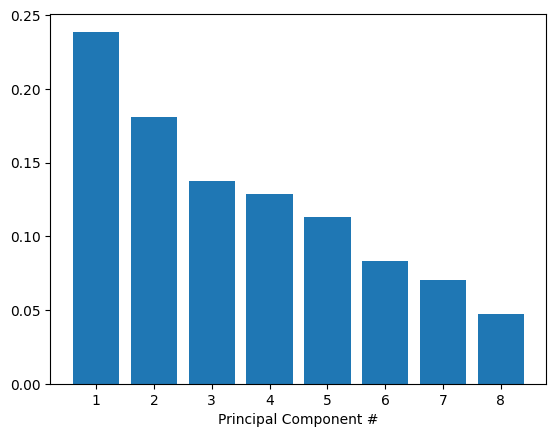

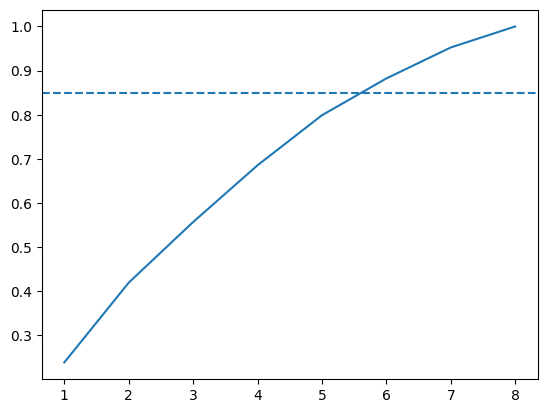

In [4]:
# For visualization purposes
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Applying PCA to determine importance of features
pca = PCA()
pca.fit(scaled_train_features)

# Explained variance by each principal component
exp_variance = pca.explained_variance_ratio_

# Visualizing the explained variance by each component
fig, ax = plt.subplots()
ax.bar(range(1, len(exp_variance) + 1), exp_variance)
ax.set_xlabel('Principal Component #')

# Cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Visualizing the cumulative explained variance
fig, ax = plt.subplots()
ax.plot(range(1, len(cum_exp_variance) + 1), cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')


# Feature Projection

In [5]:
# Reducing the features to the top 6 principal components
pca = PCA(n_components=6)
train_pca = pca.fit_transform(scaled_train_features)
test_pca = pca.transform(scaled_test_features)

# Model Training and Evaluation

#### Here, we train two different models: Decision Tree and Logistic Regression.
#### After training, we use the models to predict on our test data and then evaluate their performance.
#### The classification report provides key metrics like precision, recall, and F1-score for each class, allowing us to see how well each model is performing.


In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Decision Tree Classifier
# ------------------------

tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_pca, train_labels)
pred_labels_tree = tree.predict(test_pca)

# Logistic Regression
# -------------------

logreg = LogisticRegression(random_state=10)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

# Model Comparison
# ----------------

print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))


Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.62      0.63      0.62       315
        Rock       0.91      0.90      0.91      1270

    accuracy                           0.85      1585
   macro avg       0.76      0.77      0.77      1585
weighted avg       0.85      0.85      0.85      1585

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.75      0.55      0.63       315
        Rock       0.89      0.96      0.92      1270

    accuracy                           0.87      1585
   macro avg       0.82      0.75      0.78      1585
weighted avg       0.87      0.87      0.87      1585



# Balancing the Dataset

#### Many machine learning models perform better when the number of samples in each class are roughly equal.
#### Here, we balance our dataset by undersampling the 'Rock' genre to match the number of 'Hip-Hop' tracks.
#### This can help in improving the performance of our models, especially in terms of bias towards a particular class.


In [7]:
# Extracting samples of specific genres
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == "Hip-Hop", :]
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == "Rock", :]

# Balancing the dataset by sampling from the 'Rock' genre
rock_only = rock_only.sample(n=len(hop_only), random_state=10)

# Merging the two balanced datasets
rock_hop_bal = pd.concat([hop_only, rock_only])

# Extracting features and labels from the balanced dataset
features = rock_hop_bal.drop(['genre_top','track_id'], axis=1) 
labels = rock_hop_bal['genre_top']

# Splitting the balanced dataset
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=10)
train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))

# Cross-Validation for Model Evaluation

#### Cross-validation provides a more robust way to evaluate model performance. 
#### It reduces the risk of your model overfitting on the training set by training and evaluating the model on different subsets of the data.
#### The average score from cross-validation gives us a better idea of how the model will perform on unseen data.


In [8]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

# Creating pipelines for both models
tree_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                      ("tree", DecisionTreeClassifier(random_state=10))])
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                        ("logreg", LogisticRegression(random_state=10))])

# 10-fold cross-validation
kf = KFold(n_splits=10)

# Evaluating models using cross-validation
tree_score = cross_val_score(tree_pipe, features, labels, cv=kf)
logit_score = cross_val_score(logreg_pipe, features,labels, cv=kf)

# Averaging the cross-validation scores for each model
tree_mean = np.mean(tree_score)
logit_mean = np.mean(logit_score)
# Printing scores
print("Decision Tree Scores: \n", tree_score, "\n\n Logistic Regression Scores:\n", logit_score)
# Printing average scores
print("\n avg Decision Tree:", tree_mean, "\n\n avg Logistic Regression:", logit_mean)

Decision Tree Scores: 
 [0.74175824 0.78021978 0.79120879 0.76923077 0.7032967  0.73626374
 0.75824176 0.7967033  0.75274725 0.75274725] 

 Logistic Regression Scores:
 [0.78021978 0.77472527 0.74175824 0.7967033  0.79120879 0.77472527
 0.81318681 0.82967033 0.76923077 0.75824176]

 avg Decision Tree: 0.7582417582417582 

 avg Logistic Regression: 0.782967032967033


# Conclusion

Given the performance metrics provided for the Decision Tree and Logistic Regression models, we can conclude the following about the music genres classification task:

**The Logistic Regression model outperformed the Decision Tree model in terms of average cross-validation scores.** Specifically, the average score for the Logistic Regression model was approximately 78.30%, while the Decision Tree model achieved an average score of approximately 75.82%. This suggests that, on average, Logistic Regression is better suited for this particular classification task.

The scores from the individual folds of cross-validation show some variance, indicating that **the performance of both models is somewhat sensitive to the particular subset of data used for training and validation.** This is expected in machine learning and highlights the importance of cross-validation to get a more accurate estimate of model performance. The Decision Tree scores ranged from a low of approximately 70.33% to a high of approximately 79.67%, while the Logistic Regression scores were slightly more consistent, with a minimum score of approximately 74.18% and a maximum of approximately 82.97%.

The results suggest that Logistic Regression provides a more robust and stable performance across different subsets of the data compared to the Decision Tree. This could be due to Logistic Regression's linear nature, which may generalize better in this scenario, whereas the Decision Tree might be overfitting to the training data, leading to a more varied performance.

Furthermore, the relatively high scores of both models indicate that the features selected for the classification task are informative and relevant for distinguishing between the different music genres. However, the Logistic Regression's higher scores suggest that it is leveraging the information in a more effective manner.

In summary, for the task of classifying music genres, **Logistic Regression seems to be the more suitable model compared to the Decision Tree**, providing higher and more consistent classification accuracy across different data splits. This conclusion should guide the choice of model for deployment in a production environment for this specific task. However, it is also important to consider other factors such as interpretability, computational efficiency, and the specific requirements of the application before finalizing the model choice.